Epoch 10/200, Training Loss: 0.07376953214406967
Epoch 20/200, Training Loss: 0.03008858487010002
Epoch 30/200, Training Loss: 0.027504825964570045
Epoch 40/200, Training Loss: 0.02257421799004078
Epoch 50/200, Training Loss: 0.021945666521787643
Epoch 60/200, Training Loss: 0.019822221249341965
Epoch 70/200, Training Loss: 0.017414551228284836
Epoch 80/200, Training Loss: 0.013315796852111816
Epoch 90/200, Training Loss: 0.0062138051725924015
Epoch 100/200, Training Loss: 0.004431175533682108
Epoch 110/200, Training Loss: 0.0027233650907874107
Epoch 120/200, Training Loss: 0.0020996197126805782
Epoch 130/200, Training Loss: 0.0017205961048603058
Epoch 140/200, Training Loss: 0.0014037623768672347
Epoch 150/200, Training Loss: 0.0011996052926406264
Epoch 160/200, Training Loss: 0.0010552264284342527
Epoch 170/200, Training Loss: 0.0009535037679597735
Epoch 180/200, Training Loss: 0.0008884781273081899
Epoch 190/200, Training Loss: 0.0008491200278513134
Epoch 200/200, Training Loss: 0.0

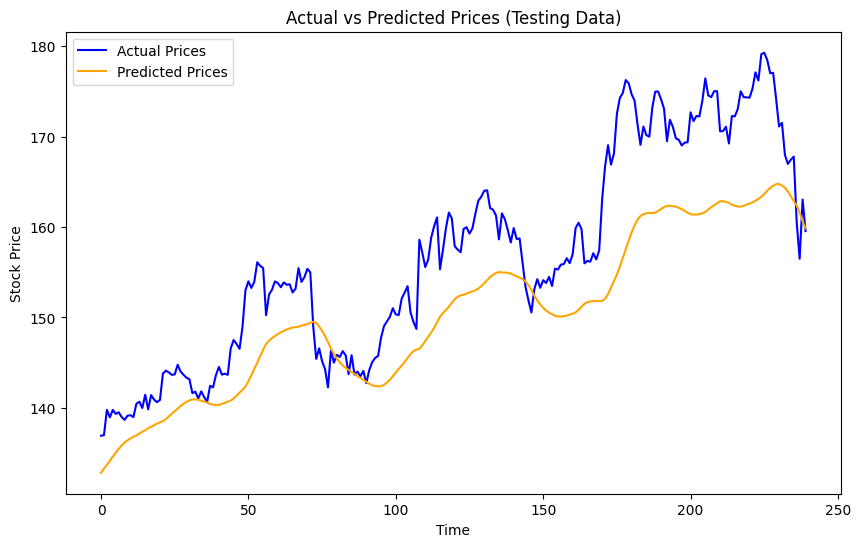

In [26]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Data Preprocessing
def load_and_preprocess_data():
    data = pd.read_csv('./all_stocks_5yr.csv')
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data = data[data['Name'] == 'AAPL']  # Example: Use only Apple stock data
    data = data[['close']].dropna()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    sequence_length = 60
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])

    X = np.array(X)
    y = np.array(y)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return torch.FloatTensor(X_train), torch.FloatTensor(y_train), torch.FloatTensor(X_test), torch.FloatTensor(y_test), scaler

# Main workflow
def main():
    # Load and preprocess data
    X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data()
    X_train, X_test = X_train.unsqueeze(2), X_test.unsqueeze(2)

    # Initialize model, loss function, and optimizer
    model = LSTM(input_size=1, hidden_size=50, num_layers=2, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    # Training loop
    epochs = 200
    for epoch in range(epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        # Training predictions
        train_predictions = model(X_train).squeeze().numpy()
        y_train_numpy = y_train.numpy()

        # Testing predictions
        test_predictions = model(X_test).squeeze().numpy()
        y_test_numpy = y_test.numpy()

    # Rescale predictions and actual values back to the original range
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
    y_train_actual = scaler.inverse_transform(y_train_numpy.reshape(-1, 1))

    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test_numpy.reshape(-1, 1))

    # Calculate errors for training and testing
    train_mse = mean_squared_error(y_train_actual, train_predictions)
    train_mae = mean_absolute_error(y_train_actual, train_predictions)
    test_mse = mean_squared_error(y_test_actual, test_predictions)
    test_mae = mean_absolute_error(y_test_actual, test_predictions)

    print(f"Training Mean Squared Error (MSE): {train_mse:.4f}")
    print(f"Training Mean Absolute Error (MAE): {train_mae:.4f}")
    print(f"Testing Mean Squared Error (MSE): {test_mse:.4f}")
    print(f"Testing Mean Absolute Error (MAE): {test_mae:.4f}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label="Actual Prices", color="blue")
    plt.plot(test_predictions, label="Predicted Prices", color="orange")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.title("Actual vs Predicted Prices (Testing Data)")
    plt.legend()
    plt.show()

    return test_predictions
if __name__ == "__main__":
    main()



Training Mean Squared Error (MSE): 24.3734
Testing Mean Squared Error (MSE): 1678.8305


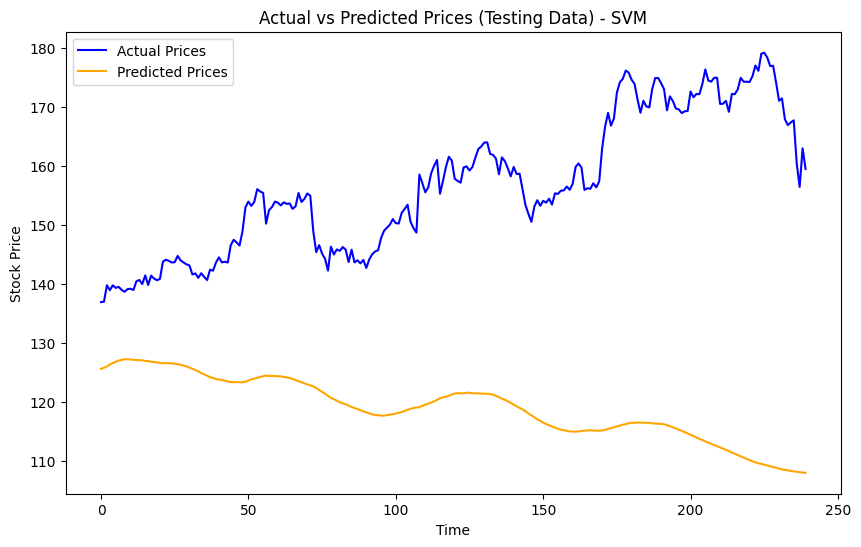

In [16]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Load and preprocess data
X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data()

# Initialize and train the SVM model
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svm_model.fit(X_train, y_train)

# Make predictions
svm_train_predictions = svm_model.predict(X_train)
test_predictions = svm_model.predict(X_test)

# Rescale predictions and actual values back to the original range
svm_train_predictions = scaler.inverse_transform(svm_train_predictions.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate errors for training and testing
train_mse = mean_squared_error(y_train_actual, svm_train_predictions)
test_mse = mean_squared_error(y_test_actual, test_predictions)

print(f"Training Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Testing Mean Squared Error (MSE): {test_mse:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(test_predictions, label="Predicted Prices", color="orange")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Prices (Testing Data) - SVM")
plt.legend()
plt.show()

Training Mean Squared Error (MSE): 22.8805
Testing Mean Squared Error (MSE): 49.0270


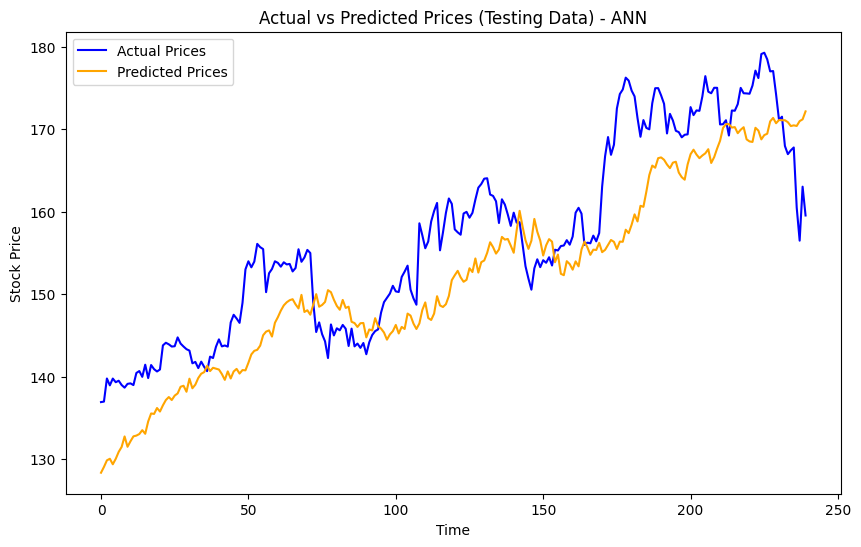

In [17]:
from sklearn.neural_network import MLPRegressor

# Initialize and train the ANN model
ann_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, activation='relu', solver='adam', random_state=42)
ann_model.fit(X_train, y_train)

# Make predictions
train_predictions = ann_model.predict(X_train)
ann_test_predictions = ann_model.predict(X_test)

# Rescale predictions and actual values back to the original range
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

ann_test_predictions = scaler.inverse_transform(ann_test_predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate errors for training and testing
train_mse = mean_squared_error(y_train_actual, train_predictions)
test_mse = mean_squared_error(y_test_actual, ann_test_predictions)

print(f"Training Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Testing Mean Squared Error (MSE): {test_mse:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(ann_test_predictions, label="Predicted Prices", color="orange")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Prices (Testing Data) - ANN")
plt.legend()
plt.show()

Epoch 10/200, Training Loss: 0.12093879282474518
Epoch 20/200, Training Loss: 0.0655224621295929
Epoch 30/200, Training Loss: 0.021951407194137573
Epoch 40/200, Training Loss: 0.022321730852127075
Epoch 50/200, Training Loss: 0.020932132378220558
Epoch 60/200, Training Loss: 0.017711492255330086
Epoch 70/200, Training Loss: 0.015341578051447868
Epoch 80/200, Training Loss: 0.011595732532441616
Epoch 90/200, Training Loss: 0.006439326796680689
Epoch 100/200, Training Loss: 0.003949975129216909
Epoch 110/200, Training Loss: 0.0031775441020727158
Epoch 120/200, Training Loss: 0.00267800223082304
Epoch 130/200, Training Loss: 0.0022554814349859953
Epoch 140/200, Training Loss: 0.0019462733762338758
Epoch 150/200, Training Loss: 0.001686871750280261
Epoch 160/200, Training Loss: 0.0014748388202860951
Epoch 170/200, Training Loss: 0.0012997074518352747
Epoch 180/200, Training Loss: 0.0011602663435041904
Epoch 190/200, Training Loss: 0.0010522597003728151
Epoch 200/200, Training Loss: 0.00097

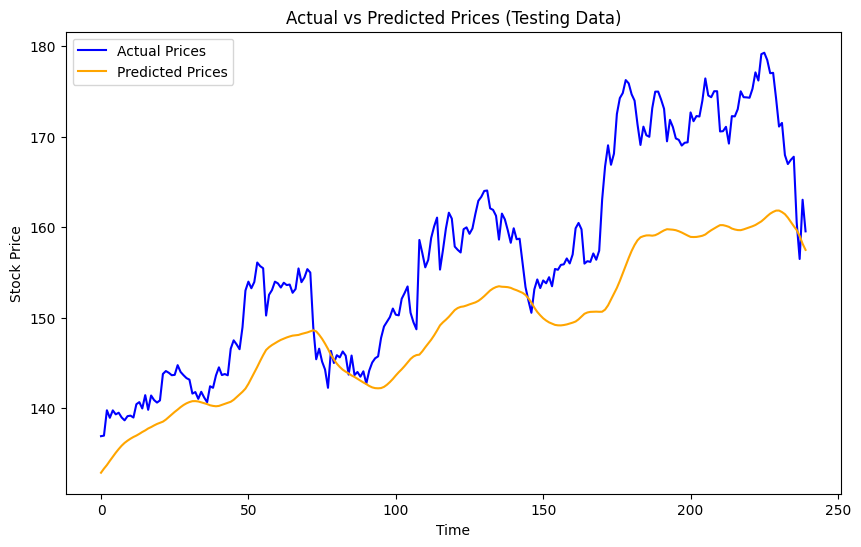

In [33]:
test_predictions_ann = ann_test_predictions
test_predictions_lstm = main()
actual = y_test_actual


[[131.63891671]
 [132.27693198]
 [132.93270073]
 [133.32530187]
 [133.26997507]
 [133.88191152]
 [134.56047226]
 [135.09790355]
 [135.93676511]
 [135.47708048]
 [135.96010889]
 [136.3899366 ]
 [136.5460623 ]
 [136.76809307]
 [137.13671703]
 [137.03150072]
 [137.91442316]
 [138.50194076]
 [138.59089367]
 [139.05522472]
 [138.93228297]
 [139.39100463]
 [139.85399852]
 [140.20748755]
 [140.20704867]
 [140.64752943]
 [140.94353907]
 [141.52147635]
 [141.73524866]
 [141.50117895]
 [142.39421984]
 [141.8896264 ]
 [142.13119118]
 [142.53167292]
 [142.75055108]
 [142.80610105]
 [143.13514942]
 [142.74124856]
 [142.89883348]
 [142.81871193]
 [142.7829427 ]
 [142.56794126]
 [142.27679977]
 [142.85738292]
 [142.49082696]
 [143.04169758]
 [143.37448875]
 [143.27725458]
 [143.66272043]
 [143.86379243]
 [144.6453286 ]
 [145.53829626]
 [146.14483994]
 [146.6008752 ]
 [147.28456563]
 [148.33169651]
 [148.93842747]
 [149.24807004]
 [149.07428195]
 [150.07791187]
 [150.58498557]
 [151.12777781]
 [151.56

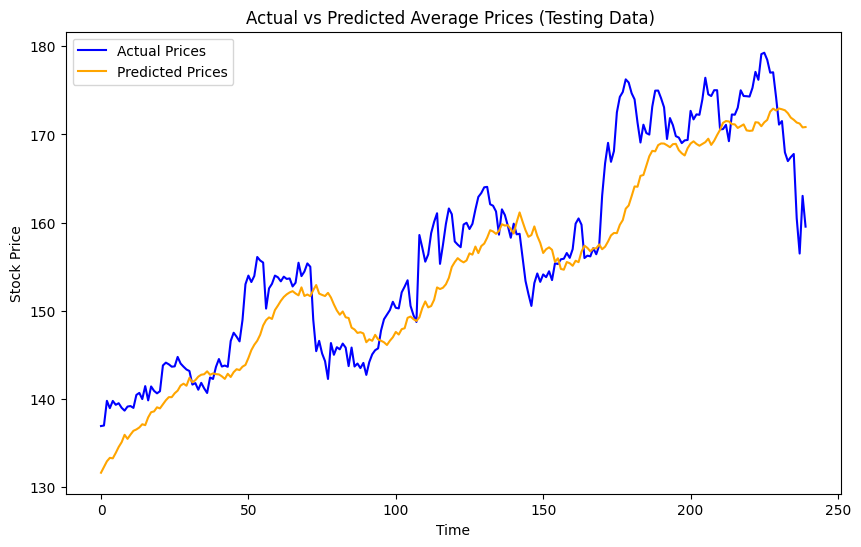

Testing Mean Squared Error (MSE): 25.8640


In [32]:

average_predictions = (test_predictions_ann + test_predictions_lstm) / 2
print(average_predictions)
test_mse = mean_squared_error(actual, average_predictions)


plt.figure(figsize=(10, 6))
plt.plot(actual, label="Actual Prices", color="blue")
plt.plot(average_predictions, label="Predicted Prices", color="orange")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Average Prices (Testing Data) ")
plt.legend()
plt.show()

print(f"Testing Mean Squared Error (MSE): {test_mse:.4f}")